In [1]:
from IPython.display import HTML

HTML('''<script>
hide_code=true; 
function code_toggle() {
   if (hide_code){
       $('div.input').hide();
   } else {
       $('div.input').show();
   }
   hide_code = !hide_code
} 
$( document ).ready(code_toggle);
</script>
NOTE: the code in this notebook is hidden for better readability.  
To toggle on/off, click <a href="javascript:code_toggle()">here</a>.''')

#Unsupervised Anomaly Detection in High Dimensions: SOD vs One-Class SVM

###[Spencer Stirling](https://github.com/sstirlin)
August 25, 2015

##Introduction

In this article we test two algorithms that detect anomalies in high-dimensional data.  For our purposes, "high-dimensional" means tens to hundreds of dimensions.  Our results might generalize to "very high-dimensional" ($100\text{,}000$ dimensions is commonly seen in NLP and image processing), but we have not carefully experimented there.

Since we rarely have training data (nor even know what we are looking for), we are only interested in *unsupervised* algorithms.

The first algorithm, **Subspace Outlier Degree (SOD)** [kriegel2009](#kriegel2009), is an unsupervised *local* anomaly detector.  "Local" means that points are compared against their nearest neighbors (*not* against the entire dataset).  The appeal of SOD is that it overcomes the curse of dimensionality that plagues distance and density-based algorithms such as [Local Outlier Factor](http://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf).  For our experiments we use the implementation found in the [`ELKI`](http://elki.dbs.ifi.lmu.de/) framework.

The second algorithm, **One-Class Support Vector Machine** [scholkopf2001](#scholkopf2001), is a semi-supervised global anomaly detector (i.e. we need a training set that contains only the "normal" class).  However, since SVM decision boundaries are soft, it can be used unsupervised as well.

We experiment with this, as well as two variants ("eta" and "robust") that were recently proposed [amer2013](#amer2013) explicitly for unsupervised applications.  We use the implementation in [`RapidMiner`](https://github.com/Markus-Go/rapidminer-anomalydetection) (which leverages a modified version of [`libsvm`](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) underneath).

All scripts and datasets can be obtained from the [github repo](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm.git).


###TL;DR

Surprisingly, we found that the ordinary one-class SVM produced the best results out of all of the algorithms tested, *even unsupervised*.  It was also the fastest.  The performance of the other algorithms was as follows:

- robust SVM was unreliable
- eta SVM quality was competitive, but it was slightly slower and is not widely implemented
- SOD quality was competitive *as long as the parameter $\text{snn}$ was tuned optimally*.  However, it was *much* slower

For SOD we observed a curious phenomenon:  the optimal parameter tuning seems to be

$$\text{snn}\gtrapprox\text{no. outliers in the dataset}$$  

In real datasets we usually do not know how many outliers to expect, hence it is difficult to tune SOD in practice.

For SVM we only studied the RBF kernel.  Two settings for the parameter $\gamma$ were investigated:  

1. "automated gamma tuning" as was proposed in [evangelista2007](#evangelista2007)
2. the simple heuristic $\gamma=\frac{1}{\text{no. of datapoints}}$

Again, our results were surprising.  We found that, although automated tuning helped for some datasets, it was disastrous in other cases.  The simple heuristic is faster and more reliable.


###sklearn Users Beware

Users of [`sklearn`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) should be aware that leaving the default argument $\gamma=0$ *enables* automated gamma tuning (despite what the documentation says).  Since we found that automated tuning was unreliable, we recommend explicitly setting the value $\gamma=\frac{1}{\text{no. of datapoints}}$.

Also, although `RapidMiner` computes an "outlier score" that can be readily used, `sklearn` only returns the decision function.  To compute the outlier score, first compute the maximum value of the decision function:

$$Q = \max_{x^\prime}\;\text{decision_function}(x^\prime)$$

Then 

$$\text{outlier_score}(x) = Q - \text{decision_function}(x)$$


##Data preparation

We prepare labelled datasets similar to those found in [amer2013](#amer2013), and we add several more.  Our procedure is to pick an "anomaly class" in each dataset and cull it to a small size compared to the other class(es).


name | original source | dim | $N_\text{anomalies}$ | $N_\text{normal}$ | anomaly class(es)
-----|--------|-----|----------------------|-------------------|-------------------
[ionosphere](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/ionosphere/ionosphere_for_elki.csv) | [UCI](https://archive.ics.uci.edu/ml/datasets/Ionosphere) | 33 | 7 | 225 | b
[shuttle](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/shuttle/shuttle_for_elki.csv) | [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29) | 9 | 772 | 40867 | 2, 3, 5, 6
[breast_cancer (Wisc. diag.)](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/breast_cancer_wisconsin_diagnostic/wdbc_for_elki.csv) | [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) | 30 | 9 | 357 | M
[satellite](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/satellite/sat_for_elki.csv) | [UCI](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Landsat+Satellite%29) | 36 | 59 | 3071 | 2, 4, 5
[mouse](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/mouse/mouse_for_elki.csv) | [ELKI](http://elki.dbs.ifi.lmu.de/wiki/DataSets) | 2 | 10 | 490 | Noise
[kddcup99_5000](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/kddcup99/kddcup_for_elki_5000.csv) | [KDD Cup](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) | 63 | 100 | 5000 | all except normal
[kddcup99_10000](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/kddcup99/kddcup_for_elki_10000.csv)| [KDD Cup](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) | 63 |200 | 10000 | all except normal
[kddcup99_20000](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/kddcup99/kddcup_for_elki_20000.csv) | [KDD Cup](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) | 63 | 400 | 20000 | all except normal
[kddcup99_100000](https://github.com/ActivisionGameScience/unsupervised_anomaly_detection_sod_vs_one_class_svm/kddcup99/kddcup_for_elki_100000.csv) | [KDD Cup](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) | 63 | 2000 | 100000 | all except normal


Each categorical variable was converted to dummy variables (using [`get_dummies`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in python).
This is included in the dimensionalities listed above.

All variables (including dummy variables) were then standardized to have mean=0, stddev=1.


##Use Precision-Recall instead of ROC

Although the ROC curve is the most popular measure of classifier quality, it is much better to use the Precision-Recall curve when the dataset is highly imbalanced [davis2006](#davis2006).  The explanation is simple.  Recall that ROC measures the true positive rate (sensitivity)

$$\text{TPR}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$

versus the false positive rate

$$\text{FPR}=\frac{\text{FP}}{\text{FP}+\text{TN}}$$

When the negative class is much larger than the positive class (as happens in anomaly detection) then, even if the false positive *rate* is small, the actual number of false positives might be large compared to the number of true positives.  The ROC curve would appear favorable, but the algorithm would be poor.

From now on we restrict our attention to the PR curve (and the area under the curve PR-AUC).


##SOD quality depends on SNN

SOD depends on three parameters:

- number of **shared nearest neighbors** $\text{snn}$
- number of **ordinary nearest neighbors** $\text{knn}$ (not important, but must be larger than $\text{snn}$.  We use $2*\text{snn}$)
- a threshold parameter $\alpha$ (we use the default value $0.8$)

It is claimed in [kriegel2009](#kriegel2009) that SOD is *not* sensitive to $\text{snn}$, provided $\text{snn}$ is sufficiently large (so there are enough nearest neighbors to compare against).  

In our experiments, however, we *do* see sensitivity to $\text{snn}$.  In the following graphs we plot the average quality (PR-AUC) versus $\text{snn}$ for each dataset.  To provide context, the vertical line depicts the number of anomalies in each dataset.  

Because of performance limitations we could not make a full parameter sweep on kddcup99_20000, and were unable to run SOD on kddcup99_100000 at all.


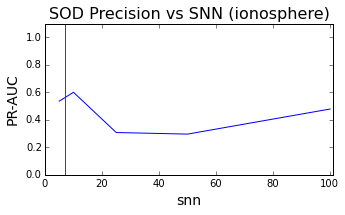

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# SOD PR-AUC vs SNN (ionosphere) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=3, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([7, 7], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([0, 101])
ax.set_title('SOD Precision vs SNN (ionosphere)', fontsize=16)
plt.show()


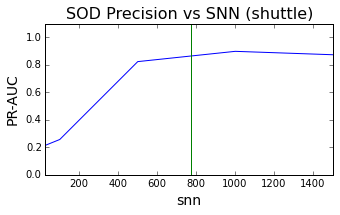

In [6]:
# SOD PR-AUC vs SNN (shuttle) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=10, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([772, 772], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([24, 1501])
ax.set_title('SOD Precision vs SNN (shuttle)', fontsize=16)
plt.show()


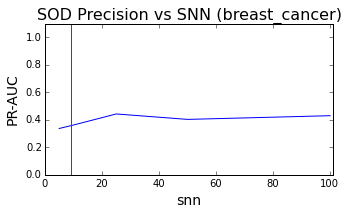

In [7]:
# SOD PR-AUC vs SNN (breast_cancer) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=17, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([9, 9], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([0, 101])
ax.set_title('SOD Precision vs SNN (breast_cancer)', fontsize=16)
plt.show()


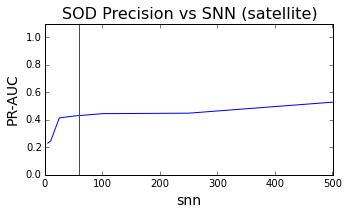

In [8]:
# SOD PR-AUC vs SNN (satellite) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=24, nrows=7, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([59, 59], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([0, 501])
ax.set_title('SOD Precision vs SNN (satellite)', fontsize=16)
plt.show()


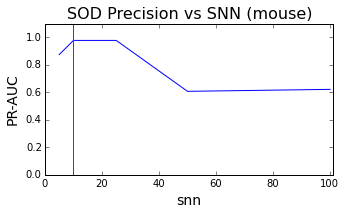

In [9]:
# SOD PR-AUC vs SNN (mouse) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=32, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([10, 10], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([0, 101])
ax.set_title('SOD Precision vs SNN (mouse)', fontsize=16)
plt.show()


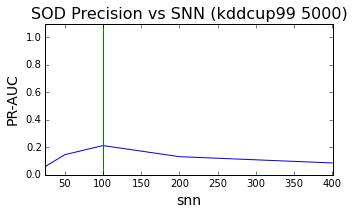

In [10]:
# SOD PR-AUC vs SNN (kddcup99_5000) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=39, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([100, 100], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([24, 401])
ax.set_title('SOD Precision vs SNN (kddcup99 5000)', fontsize=16)
plt.show()


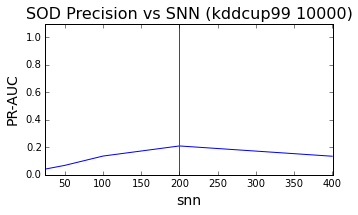

In [11]:
# SOD PR-AUC vs SNN (kddcup99_10000) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=46, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([200, 200], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([24, 401])
ax.set_title('SOD Precision vs SNN (kddcup99 10000)', fontsize=16)
plt.show()


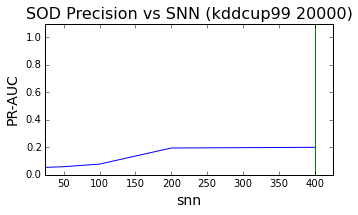

In [12]:
# SOD PR-AUC vs SNN (kddcup99_20000) 
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=53, nrows=5, usecols=[2,4])

fig = plt.figure(figsize=(5,3))
ax = fig.add_axes([0.12, 0.15, 0.8, 0.7])
ax.plot(df[2].values, df[4].values)
ax.plot([400, 400], [0, 1.1])
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('PR-AUC', fontsize=14)
ax.set_ylim([0.0, 1.1])
ax.set_xlim([24, 425])
ax.set_title('SOD Precision vs SNN (kddcup99 20000)', fontsize=16)
plt.show()


###Discussion

From the above graphs it is clear that the quality of SOD depends on the choice of $\text{snn}$.  Interestingly, the optimal setting for $\text{snn}$ appears to be approximately the same as the number of anomalies in the dataset (or slightly larger).

Since in practice we won't know the number of anomalies to expect, we won't be able to tune $\text{snn}$ effectively.  It is important to notice that the quality drops especially quickly if $\text{snn}$ is chosen too small.

##SOD running time

Since quality depends on $\text{snn}$, we need to know how running time depends on $\text{snn}$.  The plot below shows this relationship for three separate datasets: kddcup99 5000, 10000, and 20000.  Running time appears to grow linearly $\text{O}(\text{snn})$ in each case.


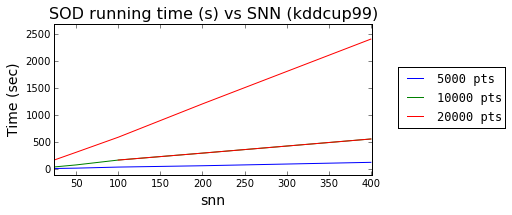

In [20]:
# SOD running time (s) vs snn
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=39, nrows=19, usecols=[2,5])

fig = plt.figure(figsize=(7,3))
ax = fig.add_axes([0.1, 0.15, 0.63, 0.7])
ax.plot(df[2].values[0:5], df[5].values[0:5], label="5000 pts")
ax.plot(df[2].values[7:12], df[5].values[7:12], label="10000 pts")
ax.plot(df[2].values[9:], df[5].values[9:], label = "20000 pts")
ax.set_xlabel('snn', fontsize=14)
ax.set_ylabel('Time (sec)', fontsize=14)
ax.set_ylim([-100, 2700])
ax.set_xlim([24, 401])
ax.set_title('SOD running time (s) vs SNN (kddcup99)', fontsize=16)
ax.legend(bbox_to_anchor=(1.44, 0.75), prop={'family': 'monospace'})
plt.show()


Likewise, we need to know how running time is affected by increasing the size of the dataset.  Below we plot several curves with fixed $\text{snn}$ and varying data size.  It turns out that the running time grows quadratically $\text{O}(n^2)$ in each case.

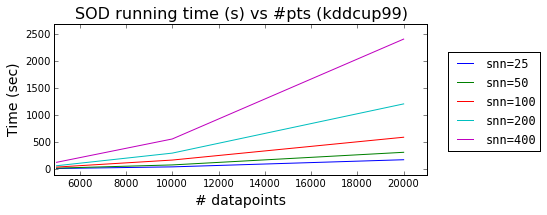

In [19]:
# SOD running time (s) vs # datapoints
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=39, nrows=19, usecols=[2,5])

fig = plt.figure(figsize=(7.5,3))
ax = fig.add_axes([0.1, 0.15, 0.69, 0.7])
ax.plot([5000,10000,20000], df[5].values[0::7], label="snn=25")
ax.plot([5000,10000,20000], df[5].values[1::7], label="snn=50")
ax.plot([5000,10000,20000], df[5].values[2::7], label="snn=100")
ax.plot([5000,10000,20000], df[5].values[3::7], label="snn=200")
ax.plot([5000,10000,20000], df[5].values[4::7], label="snn=400")
ax.set_xlabel('# datapoints', fontsize=14)
ax.set_ylabel('Time (sec)', fontsize=14)
ax.set_ylim([-100, 2700])
ax.set_xlim([4900, 21000])
ax.set_title('SOD running time (s) vs #pts (kddcup99)', fontsize=16)
ax.legend(bbox_to_anchor=(1.32, 0.85), prop={'family': 'monospace'})
plt.show()


###Discussion

Putting these together we see that SOD running time grows like $\text{O}(n^2\cdot\text{snn})$.

However, we already saw that we should scale $\text{snn}\gtrapprox(\text{no. of anomalies})$ to optimize quality.  Since $(\text{no. of anomalies})\propto(\text{size of dataset }n)$, we conclude that we should scale $\text{snn}\propto n$.

So optimal SOD has time complexity $\text{O}(n^3)$.  Below we will see that SOD is far more expensive than SVM when we compare them head-to-head.


##One-Class SVM quality

We already mentioned that we are comparing three variants of one-class SVM:  ordinary one-class SVM, eta SVM, and robust SVM.  Although we could study other kernels, in our experiments we limited ourselves to RBF.  Two settings for the parameter $\gamma$ were investigated:  

1. "automated gamma tuning" as was proposed in [evangelista2007](#evangelista2007)
2. the simple heuristic $\gamma=\frac{1}{\text{no. of datapoints}}$

In the graphs below we compare all six Precision-Recall curves for each dataset:

1. eta SVM *with* automated gamma tuning
2. eta SVM *without* automated gamma tuning
3. robust SVM *with* automated gamma tuning
4. robust SVM *without* automated gamma tuning
5. ordinary one-class SVM *with* automated gamma tuning
6. ordinary one-class SVM *without* automated gamma tuning


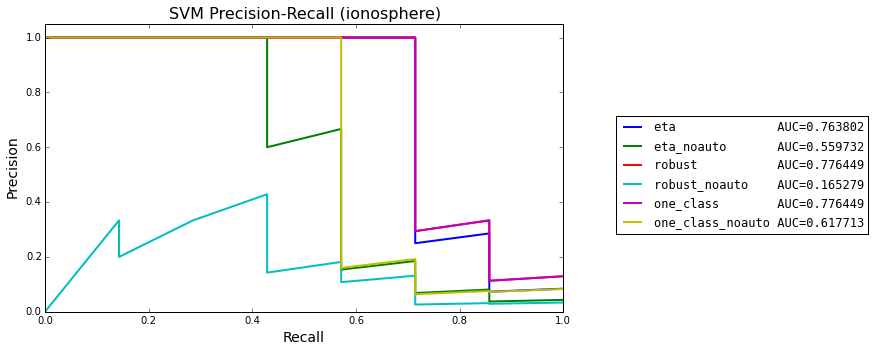

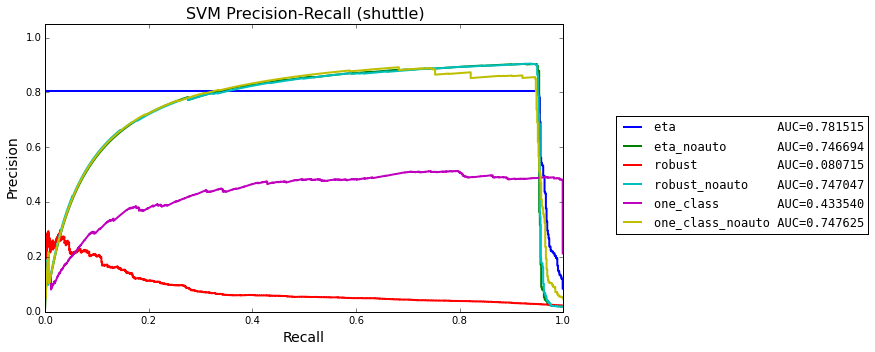

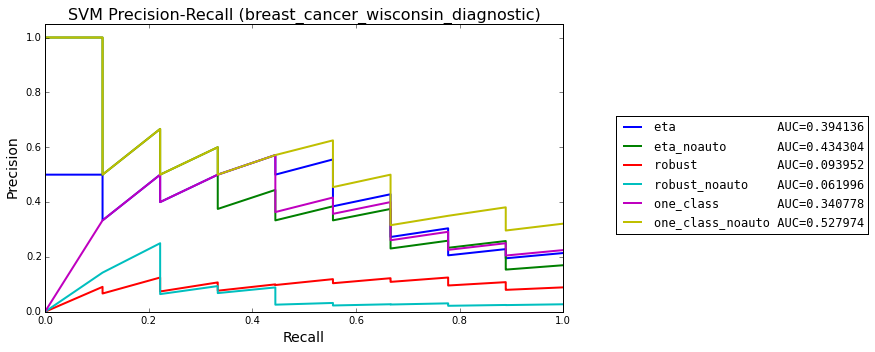

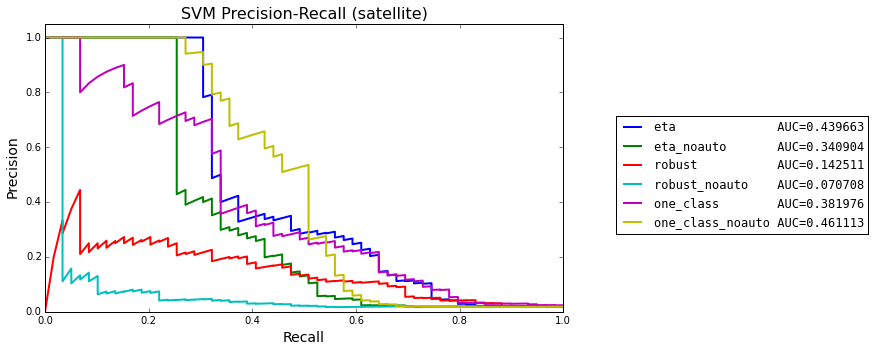

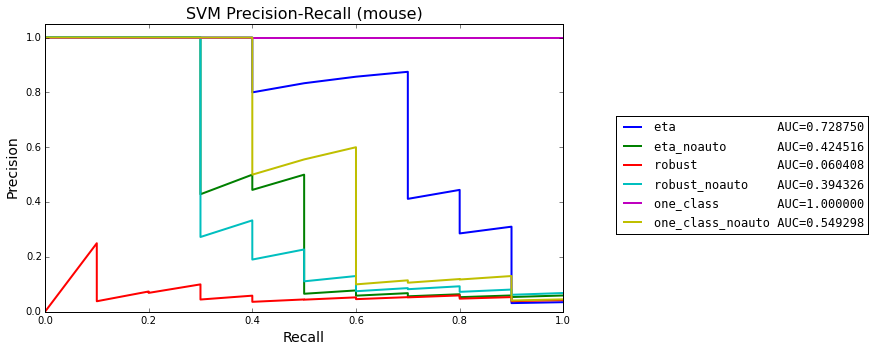

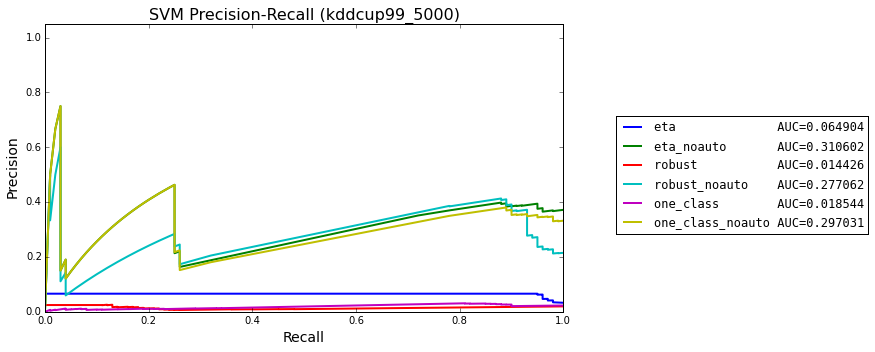

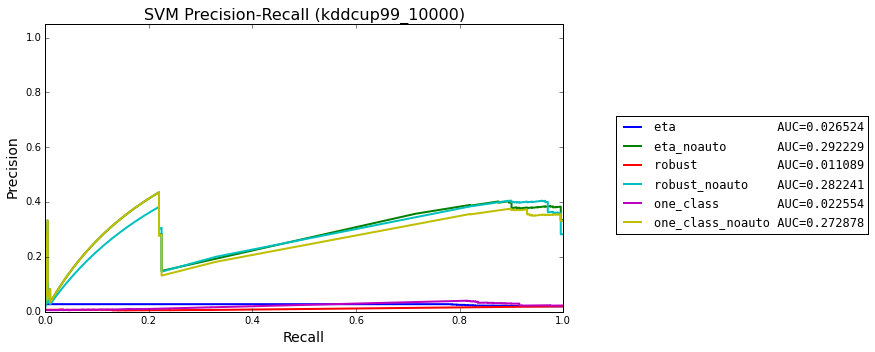

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
%matplotlib inline

# process SVM PR curves
datasets = ['ionosphere', 'shuttle', 'breast_cancer_wisconsin_diagnostic', 'satellite', 'mouse', 'kddcup99_5000', 'kddcup99_10000']
for name in datasets:

    if name == 'kddcup99_5000':
        dirname = 'kddcup99'
        subdirbase = "outputsvm_5000"
    elif name == 'kddcup99_10000':
        dirname = 'kddcup99'
        subdirbase = "outputsvm_10000"
    else:
        dirname = name
        subdirbase = "outputsvm"

    eta = pd.read_csv('%s/%s_eta/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)
    eta_no_gamma_tuning = pd.read_csv('%s/%s_eta_no_gamma_tuning/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)
    robust = pd.read_csv('%s/%s_robust/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)
    robust_no_gamma_tuning = pd.read_csv('%s/%s_robust_no_gamma_tuning/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)
    one_class = pd.read_csv('%s/%s_one_class/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)
    one_class_no_gamma_tuning = pd.read_csv('%s/%s_one_class_no_gamma_tuning/pr.txt' % (dirname, subdirbase), header=None, index_col=False, skiprows=1)

    eta_auc = auc(eta[0], eta[1])
    eta_no_gamma_tuning_auc = auc(eta_no_gamma_tuning[0], eta_no_gamma_tuning[1])
    robust_auc = auc(robust[0], robust[1])
    robust_no_gamma_tuning_auc = auc(robust_no_gamma_tuning[0], robust_no_gamma_tuning[1])
    one_class_auc = auc(one_class[0], one_class[1])
    one_class_no_gamma_tuning_auc = auc(one_class_no_gamma_tuning[0], one_class_no_gamma_tuning[1])

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_axes([0.045, 0.1, 0.6, 0.8])
    ax.plot(eta[0].values, eta[1].values, label='eta              AUC=%f' % eta_auc, lw=2)
    ax.plot(eta_no_gamma_tuning[0].values, eta_no_gamma_tuning[1].values, label='eta_noauto       AUC=%f' % eta_no_gamma_tuning_auc, lw=2)
    ax.plot(robust[0].values, robust[1].values, label='robust           AUC=%f' % robust_auc, lw=2)
    ax.plot(robust_no_gamma_tuning[0].values, robust_no_gamma_tuning[1].values, label='robust_noauto    AUC=%f' % robust_no_gamma_tuning_auc, lw=2)
    ax.plot(one_class[0].values, one_class[1].values, label='one_class        AUC=%f' % one_class_auc, lw=2)
    ax.plot(one_class_no_gamma_tuning[0].values, one_class_no_gamma_tuning[1].values, label='one_class_noauto AUC=%f' % one_class_no_gamma_tuning_auc, lw=2)
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('SVM Precision-Recall (%s)' % name, fontsize=16)
    ax.legend(bbox_to_anchor=(1.6, 0.7), prop={'family': 'monospace'})
    plt.show()


###Discussion

From the graphs it is clear that robust SVM (with or without automated gamma tuning) performs much worse on most datasets.  Since it seems to be unreliable, we drop it from further discussion. 

Now consider the effect of automated gamma tuning.  Although it helps for the "ionosphere" and "mouse" datasets, results are mixed for the "shuttle" and "satellite" datasets.  It actually *hurts* the "breast_cancer" results, and it *really hurts* the "kddcup99" results.  Since it seems to be unreliable, we cannot recommend it.

So we are left comparing eta SVM versus ordinary one-class SVM (both with automated gamma tuning *off*).  We see that the results are mostly comparable.  Since one-class SVM is standard in `libsvm`, we see no reason to use the eta variant.

##Head-to-head quality comparison:  Optimal SOD vs One-Class SVM

In the graphs below we compare ordinary one-class SVM (automated gamma tuning *off*) against SOD (where $\text{snn}$ was tuned optimally for each dataset).  We see that both algorithms are competitive, however one-class SVM seems to produce slightly better quality overall.

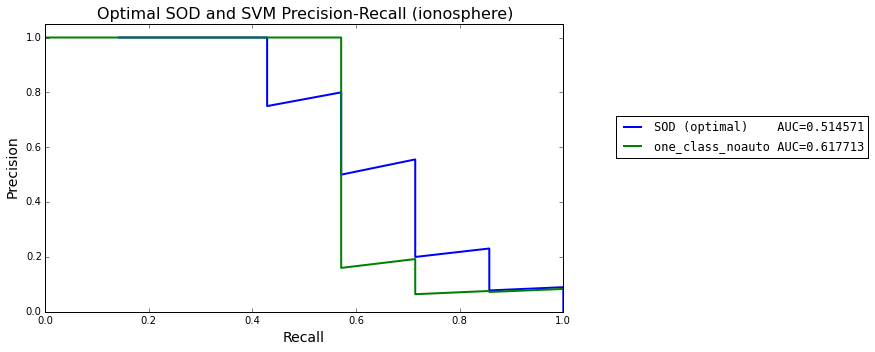

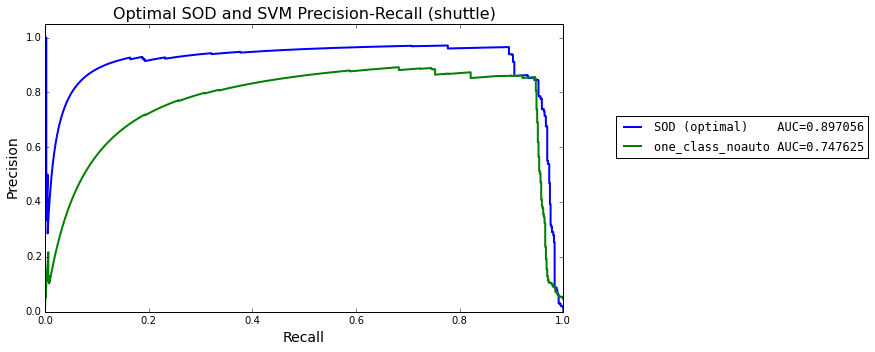

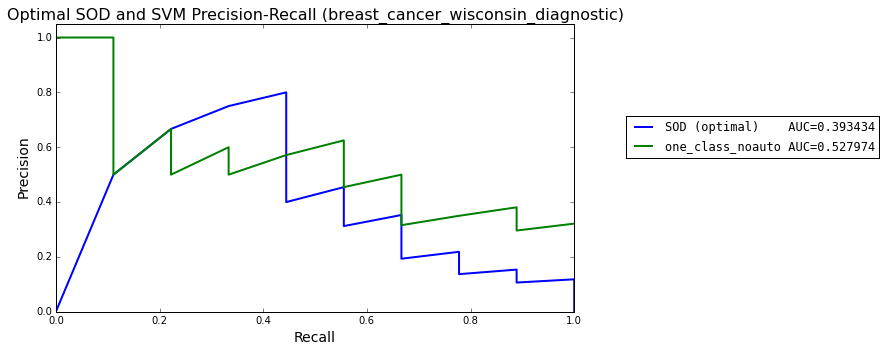

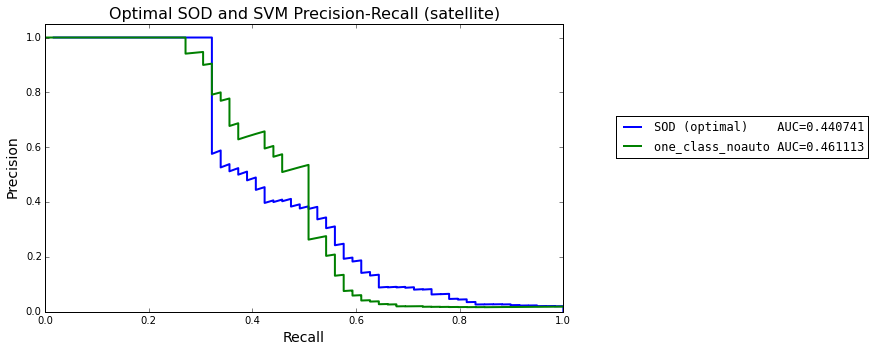

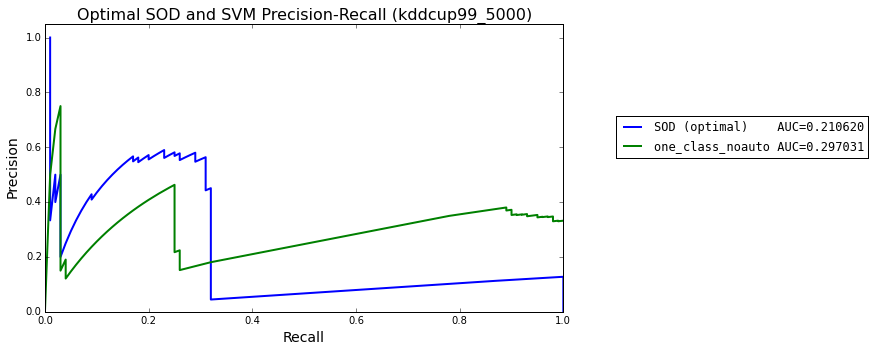

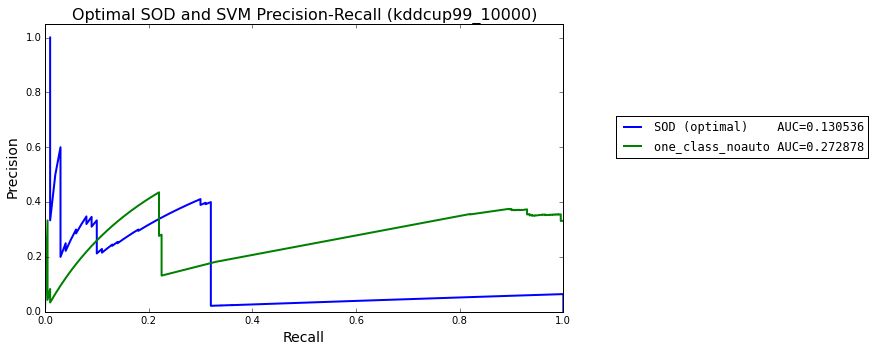

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
%matplotlib inline

# process SVM PR curves vs SOD (optimal) PR curves
datasets = ['ionosphere', 'shuttle', 'breast_cancer_wisconsin_diagnostic', 'satellite', 'kddcup99_5000', 'kddcup99_10000']
for name in datasets:

    if name == 'ionosphere':
        dirname = name
        svmsubdirbase = "outputsvm_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_10snn"        
    elif name == 'shuttle':
        dirname = name
        svmsubdirbase = "outputsvm_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_1000snn"        
    elif name == 'breast_cancer_wisconsin_diagnostic':
        dirname = name
        svmsubdirbase = "outputsvm_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_25snn"        
    elif name == 'satellite':
        dirname = name
        svmsubdirbase = "outputsvm_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_250snn"        
    elif name == 'mouse':
        dirname = name
        svmsubdirbase = "outputsvm_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_10snn"        
    elif name == 'kddcup99_5000':
        dirname = 'kddcup99'
        svmsubdirbase = "outputsvm_5000_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_5000_100snn"
    elif name == 'kddcup99_10000':
        dirname = 'kddcup99'
        svmsubdirbase = "outputsvm_10000_one_class_no_gamma_tuning"
        sodsubdirbase = "outputsod_5000_200snn"

    one_class_no_gamma_tuning = pd.read_csv('%s/%s/pr.txt' % (dirname, svmsubdirbase), header=None, index_col=False, skiprows=1)
    sod = pd.read_csv('%s/%s/pr-curve.txt' % (dirname, sodsubdirbase), header=None, index_col=False, skiprows=2, sep=' ')

    one_class_no_gamma_tuning_auc = auc(one_class_no_gamma_tuning[0], one_class_no_gamma_tuning[1])
    sod_auc = auc(sod[0], sod[1])

    fig = plt.figure(figsize=(12,5))
    ax = fig.add_axes([0.045, 0.1, 0.6, 0.8])
    ax.plot(sod[0].values, sod[1].values, label='SOD (optimal)    AUC=%f' % sod_auc, lw=2)
    ax.plot(one_class_no_gamma_tuning[0].values, one_class_no_gamma_tuning[1].values, label='one_class_noauto AUC=%f' % one_class_no_gamma_tuning_auc, lw=2)
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Optimal SOD and SVM Precision-Recall (%s)' % name, fontsize=16)
    ax.legend(bbox_to_anchor=(1.6, 0.7), prop={'family': 'monospace'})
    plt.show()


##Head-to-head time comparison:  Optimal SOD vs One-Class SVM

Finally, we compare the running time of one-class SVM (automated gamma tuning *off*) versus SOD (where $\text{snn}$ was tuned optimally for each dataset).

We already argued above that Optimal SOD running time grows as $\text{O}(n^3)$.  Our experiments verify this.
On the other hand, our experiments show that one-class SVM only grows as $\text{O}(n^2)$.

Clearly, Optimal SOD is *much* more expensive than one-class SVM.

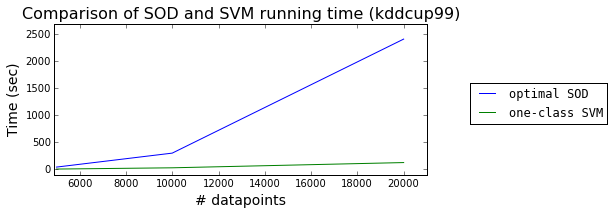

In [3]:
# SOD optimal running time (s) compared to one-class SVM running time
df = pd.read_csv('output_summary.csv', header=None, index_col=False, skiprows=39, nrows=19, usecols=[5,12])

fig = plt.figure(figsize=(7.5,3))
ax = fig.add_axes([0.1, 0.15, 0.69, 0.7])
ax.plot([5000,10000,20000], [df[5].values[2], df[5].values[10], df[5].values[18]], label="optimal SOD")
ax.plot([5000,10000,20000], [df[12].values[5], df[12].values[12], df[12].values[14]], label="one-class SVM")
ax.set_xlabel('# datapoints', fontsize=14)
ax.set_ylabel('Time (sec)', fontsize=14)
ax.set_ylim([-100, 2700])
ax.set_xlim([4900, 21000])
ax.set_title('Comparison of SOD and SVM running time (kddcup99)', fontsize=16)
ax.legend(bbox_to_anchor=(1.5, 0.65), prop={'family': 'monospace'})
plt.show()


##Conclusion

See [TL;DR](#TL;DR) in the Introduction.

##Bibliography


###kriegel2009 

[Kriegel, Kröger, Schubert, Zimek](http://www.dbs.ifi.lmu.de/Publikationen/Papers/pakdd09_SOD.pdf),
*Outlier Detection in Axis-Parallel Subspaces of High Dimensional Data*, 
Lec. Notes in Comp. Sci. Vol. 5476, 2009, pp 831-38


###scholkopf2001

[Schölkopf, Platt, Shawe-Taylor, Smola, Williamson](http://research.microsoft.com/pubs/69731/tr-99-87.pdf), 
*Estimating the Support of a High-Dimensional Distribution*, 
Neural Computation 13(7), 2001, pp 1443-71


###amer2013 

[Amer, Goldstein, Abdennadher](http://outlier-analytics.org/odd13kdd/papers/amer,goldstein,abdennadher.pdf),
*Enhancing One-class Support Vector Machines for Unsupervised Anomaly Detection*,
ODD '13, 2013, pp 8-15

###davis2006

[Davis, Goadrich](http://www.autonlab.org/icml_documents/camera-ready/030_The_Relationship_Bet.pdf),
*The Relationship Between Precision-Recall and ROC Curves*,
Intl. Proc. on Mach. Learn., 2006

###evangelista2007
[Evangelista, Embrechts, Szymanski](http://www.cs.rpi.edu/~szymansk/papers/icann07.pdf),
*Some properties of the gaussian kernel for one class learning*,
Proc. of the 17th Int. Conf. on Artificial neural networks, 
ICANN’07, pages 269–278. Springer, 2007